## Uncovering Momentum, Section 1

# Dissecting Momentum Performance

This notebook presents the results of Section 1 'Dissecting Momentum Performance' from the paper [Uncovering Momentum](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3502301). Overall, the paper aims to explore and explain the source of the momentum premium following a systematic divide-and-conquer approach proceeding from the momentum factor into the stock level. Section 1 focuses on the top-level momentum behavior by subdividing the factor performance along two dimensions: bull/bear market states and winners/losers deciles. The results, as confirmed by the notebook, demonstrate the heterogeneous behavior of momentum across these dimensions and hence suggest that each dissected case can be associated with different processes and requires independent evaluation. 

The notebook is structured as follows: 
<ol>
    <li><a href='#section_1'> Loading Data</a></li>
    <li><a href='#section_2'> Formatting Data</a></li>
    <li><a href='#section_3'> Identifying Bull and Bear Market States</a></li>
    <li><a href='#section_4'> Overview of Heterogenous Momentum Behavior</a></li>
    <li><a href='#section_5'> Momentum Analysis across Deciles and Bull/Bear States</a></li>
</ol>

In [1]:
import datetime
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import empyrical as ep

import statsmodels.api as sm
from statsmodels import regression

Defining the package for accessing the Fama French Data Library datasets

In [2]:
import pandas_datareader.data as web

In [3]:
# Function for retrieving a list of available Fama French Data Library datasets
# import pandas_datareader
# pandas_datareader.famafrench.get_available_datasets()

Defining time interval (updated to cover data through June 2021)

In [4]:
start_date, end_date = '1927', '2021-06' 

<a id='section_1'></a>
## 1. Loading Data

Momentum performance is evaluated using the [K.R. French Data Library](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html), specifically, the 'Fama/French 3 Factors' and '10 Portfolios Formed on Momentum' datasets.

In [5]:
factors_dataset = 'F-F_Research_Data_Factors' 
# 0: subsection with monthly data
factors_df = web.DataReader(factors_dataset, 'famafrench', start=start_date, end=end_date)[0]
factors_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1134 entries, 1927-01 to 2021-06
Freq: M
Data columns (total 4 columns):
Mkt-RF    1134 non-null float64
SMB       1134 non-null float64
HML       1134 non-null float64
RF        1134 non-null float64
dtypes: float64(4)
memory usage: 44.3 KB


In [6]:
mom_dataset = "10_Portfolios_Prior_12_2"
# 0: subsection with monthly value-weighted data
mom_df = web.DataReader(mom_dataset, 'famafrench', start=start_date, end=end_date)[0]
mom_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1134 entries, 1927-01 to 2021-06
Freq: M
Data columns (total 10 columns):
Lo PRIOR    1134 non-null float64
PRIOR 2     1134 non-null float64
PRIOR 3     1134 non-null float64
PRIOR 4     1134 non-null float64
PRIOR 5     1134 non-null float64
PRIOR 6     1134 non-null float64
PRIOR 7     1134 non-null float64
PRIOR 8     1134 non-null float64
PRIOR 9     1134 non-null float64
Hi PRIOR    1134 non-null float64
dtypes: float64(10)
memory usage: 97.5 KB


In [7]:
mom_df.describe()

,Lo PRIOR,PRIOR 2,PRIOR 3,PRIOR 4,PRIOR 5,PRIOR 6,PRIOR 7,PRIOR 8,PRIOR 9,Hi PRIOR
count,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000
mean,0.402196,0.722063,0.784577,0.911085,0.911570,0.976878,1.027407,1.120088,1.211182,1.514127
std,9.871497,8.082880,6.952280,6.343022,5.910908,5.767746,5.453063,5.297828,5.572909,6.452369
min,-42.260000,-40.470000,-35.170000,-32.620000,-31.550000,-30.940000,-34.730000,-27.170000,-27.200000,-28.520000
25%,-3.837500,-2.727500,-1.990000,-1.935000,-1.750000,-1.610000,-1.765000,-1.695000,-1.595000,-2.020000
50%,0.290000,0.660000,0.890000,1.085000,1.150000,1.290000,1.355000,1.345000,1.615000,1.805000
75%,4.145000,4.037500,3.760000,3.737500,3.700000,3.897500,3.990000,3.967500,4.430000,5.530000
max,93.980000,79.330000,66.380000,62.160000,60.310000,47.340000,35.400000,32.440000,32.890000,28.880000


<a id='section_2'></a>
## 2. Computing Conventional WML Factor

After loading the data, it is preliminarly formated by converting percents into decimals and subtracting the risk-free rate (RF) from the momentum deciles to compute excess returns.

In [8]:
mom_df['MKT']   = factors_df['Mkt-RF'] + factors_df['RF']

In [9]:
factors_df = factors_df*0.01
mom_df = mom_df*0.01

ex_mom_df = mom_df.sub(factors_df['RF'], axis=0)
ex_mom_df.rename(columns={'Hi PRIOR': 'W10', 'Lo PRIOR': 'L10'},  inplace=True)

Finally, adding the WML factor.

In [10]:
ex_mom_df['WML10'] = ex_mom_df['W10'] - ex_mom_df['L10']

In [11]:
ex_mom_df.head(2)

,L10,PRIOR 2,PRIOR 3,PRIOR 4,PRIOR 5,PRIOR 6,PRIOR 7,PRIOR 8,PRIOR 9,W10,MKT,WML10
Date,,,,,,,,,,,,
1927-01,-0.0357,-0.0487,0.0241,-0.0057,-0.0066,0.0071,0.0052,0.0011,-0.0068,-0.0049,-0.0006,0.0308
1927-02,0.0716,0.0578,0.0607,0.0893,0.0354,0.0390,0.0255,0.0302,0.0394,0.0671,0.0418,-0.0045


<a id='section_3'></a>
## 3. Identifying Bull & Bear Market Intervals

For subsequent analysis of heterogenous momentum behavior, this section creates a bear market mask to identify and select momentum data seperately for bull and bear market intervals. The corresponding bull market state intervals are identified based on cumulative two year past returns with nonnegative values as computed by [Daniel and Moskowitz (2016)](https://www.sciencedirect.com/science/article/pii/S0304405X16301490).

In [12]:
def moving_cum(symbol, window=24):
    return (1. + symbol).rolling(window).agg(lambda x: x.prod()) - 1.

In [13]:
mkt_bear_mask = moving_cum(mom_df["MKT"])  < 0

ex_mom_bull_df = ex_mom_df.loc[~mkt_bear_mask]
ex_mom_bear_df = ex_mom_df.loc[mkt_bear_mask]

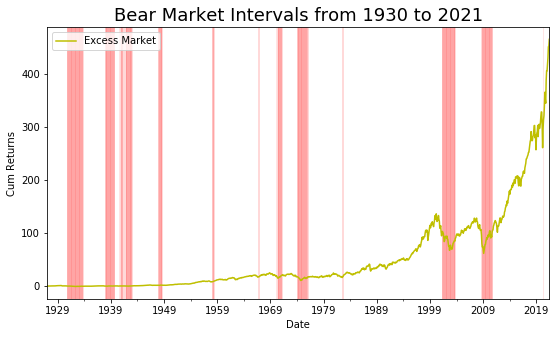

In [14]:
cum_exmkt = np.cumprod(ex_mom_df['MKT']+1) - 1
cum_exmkt.plot(figsize=(9, 5), color='y')

for month in ex_mom_bear_df.index:
    m1 = datetime.strptime(str(month), "%Y-%m")
    m2 = m1 + relativedelta(months=1)
    plt.axvspan(m1, m2, color="red", alpha=0.1)
    
plt.title('Bear Market Intervals from 1930 to 2021', fontsize=18)
plt.ylabel('Cum Returns')
plt.legend(['Excess Market'], loc = 'upper left')
plt.margins(x=0)
    
plt.show()

<a id='section_4'></a>
## 4. Overview of Heterogenous Momentum  Behavior

This section replicates (and updates time interval up to June 2021) Table 1 from the paper Uncovering Momentum. The results demonstrate the heterogeneous behavior of momentum depending on the decile and market state components. The corresponding table compares the performance of excess market (MKT), conventional winners-minus-losers momentum strategy computed from the top/bottom 10% portfolios (WML10), and the top decile winners (W10) and losers (L10) components. Reported statistics encompass the annual mean, volatility, max drawdown, alpha and beta for both the full and bull-only market states. 

According to the table, past winners represent the solo driver producing annual mean with positive beta greater than one during the bull state. Losers in the bull state in contrast generate a small annual mean as a byproduct of the difference between a negative alpha and beta of the winners level. During the bear state, the beta parameters of past winners are substantially reduced and, concurrently, the past loser’s beta is increased. 

In [15]:
def calculate_t1(momentum_data):
    rows = ['MKT', 'WML10', 'W10', 'L10']
    cols = ['annual_mean', 'annual volatility', 'max drawdown', 'annual alpha', 'beta']
    
    am = momentum_data[rows].mean()*12*100
    av = momentum_data[rows].apply(lambda x: ep.annual_volatility(x, period='monthly')*100)
    md = momentum_data[rows].apply(lambda x: ep.max_drawdown(x))
    alpha = momentum_data[rows].apply(lambda x: ep.alpha(x, ex_mom_df['MKT'], risk_free=0.0, annualization=1)*12*100)
    beta = momentum_data[rows].apply(lambda x: ep.beta(x, ex_mom_df['MKT'], risk_free=0.0))

    table_df = pd.concat([am, av, md, alpha, beta], axis=1, keys=cols)
    
    return table_df

### 4.1 Full interval

In [16]:
calculate_t1(ex_mom_df)

,annual_mean,annual volatility,max drawdown,annual alpha,beta
MKT,8.240635,18.548587,-0.846853,0.000000,1.000000
WML10,13.343175,27.373799,-0.956156,17.877928,-0.550292
W10,14.939259,22.382170,-0.782865,6.503583,1.023668
L10,1.596085,34.262345,-0.998117,-11.374345,1.573960


### 4.2 Bull market

In [17]:
calculate_t1(ex_mom_bull_df)

,annual_mean,annual volatility,max drawdown,annual alpha,beta
MKT,10.459453,14.902088,-0.466216,0.000000,1.000000
WML10,16.325811,21.224032,-0.646106,17.332089,-0.096208
W10,18.122021,21.338362,-0.503263,5.147155,1.240492
L10,1.796211,24.981218,-0.963337,-12.184934,1.336699


<a id='section_5'></a>
##  5. Momentum Analysis across Deciles and Bull/Bear States

This section proceeds with Table 2 from the paper for delving further into examining the asymmetric performance of momentum deciles during the bull and bear market states. Reported in the table are the alpha and beta perameters with corresponding t-statistics for each decile momentum portfolio seperately across the two market states. 

Focusing first solely on the bull market, alpha exhibits a positive linear shape and beta has a U-shape pattern. The results reinforce past research that going long the winners and short the losers generates positive alpha and simultaneously closely hedges the market beta. The latter parameter however is significant across all portfolios, while the former has a significant t-statistic only for the top and bottom 3 deciles. During the bear market, alpha is not significant across all decile portfolios with beta gradually declining from L10 to W10.

In [18]:
def calculate_t2(momentum_data):
    ex_mkt = momentum_data['MKT'].values
    x1 = sm.add_constant(ex_mkt)
    
    rows = list(set(ex_mom_bull_df.columns) - set(['MKT', 'WML10']))
    rows.sort()
    cols = ['alpha', 't-stat', 'beta', 't-stat']

    t2_results = []

    for i, column in enumerate(rows):
        y = momentum_data[column].values
        model = regression.linear_model.OLS(y, x1).fit()   
        t2_results.append([model.params[0]*12*100,model.tvalues[0], model.params[1],model.tvalues[1]])
    
    return pd.DataFrame(t2_results, index=rows, columns=cols)

### 5.1 Bull market

In [19]:
calculate_t2(ex_mom_bull_df)

,alpha,t-stat,beta,t-stat
L10,-12.184934,-7.044476,1.336699,40.683070
PRIOR 2,-5.590868,-4.560239,1.112338,47.763877
PRIOR 3,-2.753556,-2.805614,0.988225,53.008353
PRIOR 4,-0.972796,-1.228041,0.950380,63.160101
PRIOR 5,0.011048,0.016144,0.923368,71.031848
PRIOR 6,0.240977,0.399856,0.958858,83.760067
PRIOR 7,1.258084,1.960282,0.960342,78.775154
PRIOR 8,2.256384,3.309765,0.980785,75.737796
PRIOR 9,2.836524,3.562083,1.051570,69.520063
W10,5.147155,4.209026,1.240492,53.402631


### 5.2 Bear market

In [20]:
calculate_t2(ex_mom_bear_df)

,alpha,t-stat,beta,t-stat
L10,6.598350,1.026200,1.877174,31.350691
PRIOR 2,7.515906,1.691302,1.625434,39.278498
PRIOR 3,3.492027,1.020324,1.407595,44.165589
PRIOR 4,5.286702,1.825599,1.279772,47.456867
PRIOR 5,1.361260,0.527659,1.173887,48.863485
PRIOR 6,2.909372,1.408057,1.118466,58.128558
PRIOR 7,0.857825,0.420742,0.976335,51.423533
PRIOR 8,1.113826,0.580042,0.870561,48.684129
PRIOR 9,0.964791,0.428372,0.849360,40.497230
W10,0.948233,0.295765,0.759423,25.436715
